In [1]:
import torch
import torch.nn as nn
import numpy as np

import os
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from dataset_org import get_rays
from rendering import rendering
from model import Voxels, Nerf
from ml_helpers import training

# Camera / Dataset

In [2]:
import torch
from torch.utils.data import DataLoader

# Batch size
batch_size = 1024

# Fetch rays (might be [N,H,W,3], [H,W,3], or already flattened [M,3])
o, d, target_px_values = get_rays(datapath='pollen_60', mode='train')

print(f"Fetched o.shape={o.shape}, dims={o.ndim}")

# Dynamically flatten for training
o_flat, d_flat, t_flat = None, None, None
if o.ndim == 4:
    N, H, W, C = o.shape
    o_flat = torch.from_numpy(o).reshape(-1, C).float()
    d_flat = torch.from_numpy(d).reshape(-1, C).float()
    t_flat = torch.from_numpy(target_px_values).reshape(-1, C).float()
elif o.ndim == 3:
    H, W, C = o.shape
    o_flat = torch.from_numpy(o).reshape(-1, C).float()
    d_flat = torch.from_numpy(d).reshape(-1, C).float()
    t_flat = torch.from_numpy(target_px_values).reshape(-1, C).float()
elif o.ndim == 2:
    o_flat = torch.from_numpy(o).float()
    d_flat = torch.from_numpy(d).float()
    t_flat = torch.from_numpy(target_px_values).float()
else:
    raise ValueError(f"Unsupported o.ndim={o.ndim}")

# Training DataLoader
dataset = torch.cat((o_flat, d_flat, t_flat), dim=1)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Warm-up loader: center-crop half the spatial dims if available
if o.ndim >= 3:
    crop_frac = 0.5
    crop_h = int((H if o.ndim==4 else H) * crop_frac)
    crop_w = int((W if o.ndim==4 else W) * crop_frac)
    start_h = ((H if o.ndim==4 else H) - crop_h) // 2
    start_w = ((W if o.ndim==4 else W) - crop_w) // 2

    if o.ndim == 4:
        o_crop = o[:, start_h:start_h+crop_h, start_w:start_w+crop_w, :]
        d_crop = d[:, start_h:start_h+crop_h, start_w:start_w+crop_w, :]
        t_crop = target_px_values[:, start_h:start_h+crop_h, start_w:start_w+crop_w, :]
    else:
        o_crop = o[start_h:start_h+crop_h, start_w:start_w+crop_w, :]
        d_crop = d[start_h:start_h+crop_h, start_w:start_w+crop_w, :]
        t_crop = target_px_values[start_h:start_h+crop_h, start_w:start_w+crop_w, :]

    C_crop = o_crop.shape[-1]
    o_crop_flat = torch.from_numpy(o_crop).reshape(-1, C_crop).float()
    d_crop_flat = torch.from_numpy(d_crop).reshape(-1, C_crop).float()
    t_crop_flat = torch.from_numpy(t_crop).reshape(-1, C_crop).float()

    warmup_dataset = torch.cat((o_crop_flat, d_crop_flat, t_crop_flat), dim=1)
    dataloader_warmup = DataLoader(warmup_dataset, batch_size=batch_size, shuffle=True)
    print(f"Warm-up crop: {crop_h}×{crop_w}, total rays={len(warmup_dataset)}")
else:
    dataloader_warmup = None
    print("Skipping warm-up loader: spatial dims unknown")

# Test loader
test_o, test_d, test_t = get_rays('pollen_60', mode='test')
print(f"Fetched test_o.shape={test_o.shape}, dims={test_o.ndim}")

# Flatten test similarly
t_flatest, d_flatest, t_flatest = None, None, None
if test_o.ndim >= 3:
    C_test = test_o.shape[-1]
    t_flatest = torch.from_numpy(test_o.reshape(-1, C_test)).float()
    d_flatest = torch.from_numpy(test_d.reshape(-1, C_test)).float()
    t_flatest = torch.from_numpy(test_t.reshape(-1, C_test)).float()
else:
    t_flatest = torch.from_numpy(test_o).float()
    d_flatest = torch.from_numpy(test_d).float()
    t_flatest = torch.from_numpy(test_t).float()

test_dataset = torch.cat((t_flatest, d_flatest, t_flatest), dim=1)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train rays={len(dataset)}, Test rays={len(test_dataset)}")
print(f"Train shape={dataset.shape}, Test shape={test_dataset.shape}")


Fetched o.shape=(54, 160000, 3), dims=3
Warm-up crop: 27×80000, total rays=2160000
Fetched test_o.shape=(6, 160000, 3), dims=3
Train rays=8640000, Test rays=960000
Train shape=torch.Size([8640000, 9]), Test shape=torch.Size([960000, 9])


# Training

Epoch 1/1: 100%|██████████| 2110/2110 [00:35<00:00, 59.62it/s]

[Epoch 1]  Avg Loss: 0.0185  |  Avg PSNR: 21.80 dB


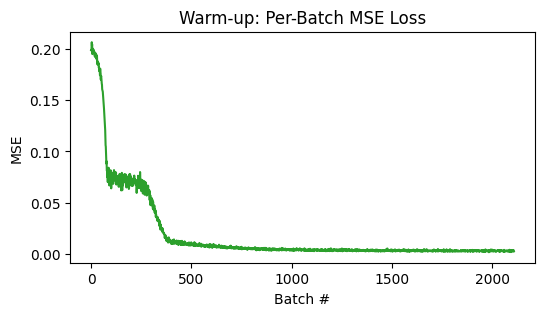

Epoch 1/10: 100%|██████████| 8438/8438 [02:23<00:00, 58.77it/s]


[Epoch 1]  Avg Loss: 0.0013  |  Avg PSNR: 29.17 dB


Epoch 2/10: 100%|██████████| 8438/8438 [02:24<00:00, 58.43it/s]


[Epoch 2]  Avg Loss: 0.0010  |  Avg PSNR: 30.51 dB


Epoch 3/10: 100%|██████████| 8438/8438 [02:21<00:00, 59.52it/s]


[Epoch 3]  Avg Loss: 0.0008  |  Avg PSNR: 31.58 dB


Epoch 4/10: 100%|██████████| 8438/8438 [02:29<00:00, 56.61it/s]


[Epoch 4]  Avg Loss: 0.0006  |  Avg PSNR: 32.63 dB


Epoch 5/10: 100%|██████████| 8438/8438 [02:55<00:00, 47.96it/s]


[Epoch 5]  Avg Loss: 0.0005  |  Avg PSNR: 33.70 dB


Epoch 6/10:   5%|▌         | 452/8438 [00:08<02:22, 56.14it/s]


KeyboardInterrupt: 

In [3]:
import matplotlib.pyplot as plt

device = "cuda"


torch.manual_seed(42)
np.random.seed(42)


tn, tf           = 8.0, 12.0
nb_epochs        = 10
lr, gamma        = 1e-4, 0.5
nb_bins          = 100

model     = Nerf(hidden_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[5, 10], gamma=gamma
)

# --- Warm-up (1 epoch on the center-crop loader) ---
batch_wu, epoch_wu, psnr_wu = training(
    model, optimizer, scheduler,
    tn, tf, nb_bins,
    nb_epochs=1,
    data_loader=dataloader_warmup,
    device=device
)

# Plot warm-up per-batch loss
plt.figure(figsize=(6,3))
plt.plot(batch_wu, color='C2')
plt.title("Warm-up: Per-Batch MSE Loss")
plt.xlabel("Batch #")
plt.ylabel("MSE")
plt.show()

# --- Main training (full data) ---
batch_tr, epoch_tr, psnr_tr = training(
    model, optimizer, scheduler,
    tn, tf, nb_bins,
    nb_epochs=nb_epochs,
    data_loader=dataloader,
    device=device
)

# Plot main per-batch loss
plt.figure(figsize=(6,3))
plt.plot(batch_tr, color='C0')
plt.title("Training: Per-Batch MSE Loss")
plt.xlabel("Batch #")
plt.ylabel("MSE")
plt.show()

# Plot per-epoch averages & PSNR (combined warm-up + main)
all_epoch_losses = epoch_wu + epoch_tr
all_epoch_psnrs  = psnr_wu  + psnr_tr
epochs = list(range(1, 1 + len(all_epoch_losses)))

fig, ax1 = plt.subplots(figsize=(8,4))
ax2 = ax1.twinx()
ax1.plot(epochs, all_epoch_losses, '-o', color='C0', label='Avg MSE Loss')
ax2.plot(epochs, all_epoch_psnrs, '--s', color='C1', label='Avg PSNR (dB)')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Avg MSE Loss', color='C0')
ax2.set_ylabel('Avg PSNR (dB)', color='C1')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title("Epoch-wise Metrics (Warm-up + Training)")
plt.show()


In [4]:
torch.save(model, "model_nerf5")